In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Prepare data

In [1]:
class Vector(object):

    def __init__(self, start, end):
        self.start = start
        self.end = end
        self.centroid = (start + end) / 2
        
    def __sub__(self, other):
        return Vector(self.end, other.start)
    
    def intersects(self, other):
        # check if two vectors intersect
        return self.start <= other.end and other.start <= self.end
    
    def __len__(self):
        return self.end - self.start
    
    def __str__(self):
        return f'({self.start}, {self.end})'

KeyboardInterrupt: 

In [ ]:
df = pd.read_csv('../datasets/fluencybank/csv/test/reading_test.csv')
df['timevr'] = df.iloc[:, 2:].apply(lambda row: Vector(row[0], row[1]), axis=1)
df['annotations'] = df.iloc[:, 2:].apply(lambda row: [Vector(row[0], row[1]), row[2:] ], axis=1)
df_ann = df[df['anotator'].isin(['A1', 'A2', 'A3'])]
df_gold = df[df['anotator'] == 'Gold']
df.head()

,media_file,anotator,start,end,FP,SR,ISR,MUR,P,B,NV,V,FG,HM,ME,T,timevr,annotations
0,50fb.wav,A1,9267,9597,0,0,0,0,1,0,0,0,0,0,0,0,"(9267, 9597)","[(9267, 9597), [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,50fb.wav,A1,10096,10738,0,0,0,0,1,0,0,0,0,0,0,0,"(10096, 10738)","[(10096, 10738), [0, 0, 0, 0, 1, 0, 0, 0, 0, 0..."
2,50fb.wav,A1,12176,19803,0,0,0,0,0,0,0,1,1,0,0,1,"(12176, 19803)","[(12176, 19803), [0, 0, 0, 0, 0, 0, 0, 1, 1, 0..."
3,50fb.wav,A1,28352,41588,0,0,0,0,0,0,0,1,0,0,0,1,"(28352, 41588)","[(28352, 41588), [0, 0, 0, 0, 0, 0, 0, 1, 0, 0..."
4,50fb.wav,A1,42352,48470,0,1,0,0,0,0,0,1,0,0,0,2,"(42352, 48470)","[(42352, 48470), [0, 1, 0, 0, 0, 0, 0, 1, 0, 0..."


In [4]:
#  define Distance functions

def iou(a:Vector, b: Vector):
    intersection = max(0, min(a.end, b.end) - max(a.start, b.start))
    union = len(a) + len(b) - intersection
    return intersection / union

def precision(a, b):
    true_positive = a==b
    false_positive = a!=b
    return true_positive / (true_positive + false_positive)

def recall(a, b):
    true_positive = a==b
    false_negative = a!=b
    return true_positive / (true_positive + false_negative)

def f1_score(a, b):
    p = precision(a, b)
    r = recall(a, b)
    return 2 * (p * r) / (p + r)

def iou_multiple(vas, vbs):
    return np.mean([iou(va, vb) for va in vas for vb in vbs])

def normalized_hamming_distance(label1, label2):
    differences = sum(1 for l1, l2 in zip(label1[1], label2[1]) if l1 != l2)
    hamming_distance = differences / len(label1)
    return hamming_distance

def normalized_ordinal_distance(ordinal1, ordinal2, max_value=3):
    ordinal_distance = abs(ordinal1 - ordinal2) / max_value
    return ordinal_distance

def normalized_ordinal_distance_multiple(ordinal1s, ordinal2s, max_value):
    return np.mean([normalized_ordinal_distance(o1, o2) for o1 in ordinal1s for o2 in ordinal2s])

def normalized_hamming_distance_multiple(labels1, labels2):
    return np.mean([normalized_hamming_distance(l1, l2) for l1 in labels1 for l2 in labels2])

def score(row1, row2, weights=(0.33, 0.33, 0.34)):
    # iou_score = iou(row1[0], row2[0])
    hamming_score = normalized_hamming_distance(row1[1], row2[1])
    ordinal_score = normalized_ordinal_distance(row1[2][0], row2[2][0], 3)
    return sum([hamming_score * weights[1], ordinal_score * weights[2]])

def score_multiple(row1, row2):
    return np.mean([score(r1, r2) for r1 in row1 for r2 in row2])



In [5]:
#  Unionize the vector ranges in to similar groups

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import euclidean_distances
from collections import defaultdict
import copy

def unionize_vectorrange_sequence(vectorranges):
    min_s = min([vr.start for vr in vectorranges])
    max_e = max([vr.end for vr in vectorranges])
    return Vector(min_s, max_e)

def fragment_by_overlaps(annodf, uid_colname, item_colname, label_colname, decomp_fn, dist_fn=None, gold_df=None):
    resultdfs = []
    for item_id in annodf[item_colname].unique():
        idf = annodf[annodf[item_colname] == item_id]
        vectorranges = [vas[0] for vas in idf[label_colname]]

        regions = decomp_fn(vectorranges, dist_fn=dist_fn)
        origItemID = []
        newItemID = []
        newItemVR = []
        uid = []
        label = []
        goldtimevr = []
        goldlabel = []
        matrix_for_fleiss = []
        for region in regions:
            for i, row in idf.iterrows():
                if region.intersects(row[label_colname][0]):
                    origItemID.append(item_id)
                    newItemID.append(F"{item_id}-{region}")
                    newItemVR.append(region)
                    uid.append(row[uid_colname])
                    label.append(row[label_colname])
                    matrix_for_fleiss.append(row[label_colname])
                    if gold_df is not None:
                        # get the gold label that intersects with the region
                        gold_timevr = [vr[0] for vr in gold_df[(gold_df[item_colname] == item_id)][label_colname] if region.intersects(vr[0])]
                        gold_timevr = gold_timevr[0] if len(gold_timevr) > 0 else None
                        goldtimevr.append(gold_timevr)

                        gold_label = [lbl[1] for lbl in gold_df[(gold_df[item_colname] == item_id)][label_colname] if region.intersects(lbl[0])]
                        gold_label = gold_label[0] if len(gold_label) > 0 else None
                        goldlabel.append(gold_label)
                    else:
                        goldtimevr.append(None)
                else:
                    matrix_for_fleiss.append([])
        resultdfs.append(pd.DataFrame({"origItemID":origItemID, "newItemID":newItemID, "newItemVR":newItemVR, uid_colname:uid, label_colname:label, "gold":gold}))
    return pd.concat(resultdfs)

def decomp_fn(vectorranges, use_centroids=True, dist_fn=None):

    if use_centroids:
        centroids = np.array([vr.centroid for vr in vectorranges]).reshape(-1, 1)
        # dists = euclidean_distances(centroids)
        # mean_dist = np.std(dists)
        mean_dist = 1000
        clustering = AgglomerativeClustering(n_clusters=None,
                                             distance_threshold=mean_dist)
        clustering.fit(centroids)
    else:
        dists = np.array([[1 - iou(a, b) for a in vectorranges] for b in vectorranges])
        mean_dist = np.std(dists)
        clustering = AgglomerativeClustering(n_clusters=None,
                                             distance_threshold=mean_dist,
                                             affinity="precomputed",
                                             linkage="average")
        clustering.fit(dists)
        
    labels = clustering.labels_
    labeldict = defaultdict(list)
    for i, label in enumerate(labels):
        labeldict[label].append(i)
    result = []
    for indices in labeldict.values():
        uv = unionize_vectorrange_sequence(np.array(vectorranges)[np.array(indices)])
        result.append(uv)

    return result

grannodf = fragment_by_overlaps(df_ann, "anotator", "media_file", "annotations", decomp_fn, gold_df=df_gold)
grannodf['gold'] = grannodf['gold'].apply(lambda x: x[0] if len(x) > 0 else None)
grannodf.head()

,origItemID,newItemID,newItemVR,anotator,annotations,gold
0,50fb.wav,"50fb.wav-(9267, 9597)","(9267, 9597)",A1,"[(9267, 9597), [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",None
1,50fb.wav,"50fb.wav-(10050, 10738)","(10050, 10738)",A1,"[(10096, 10738), [0, 0, 0, 0, 1, 0, 0, 0, 0, 0...","(10050, 10738)"
2,50fb.wav,"50fb.wav-(10050, 10738)","(10050, 10738)",A2,"[(10050, 10550), [0, 0, 0, 0, 1, 0, 0, 0, 0, 1...","(10050, 10738)"
3,50fb.wav,"50fb.wav-(11710, 19850)","(11710, 19850)",A1,"[(12176, 19803), [0, 0, 0, 0, 0, 0, 0, 1, 1, 0...","(11710, 19850)"
4,50fb.wav,"50fb.wav-(11710, 19850)","(11710, 19850)",A2,"[(12470, 19020), [0, 0, 0, 0, 0, 0, 0, 1, 1, 0...","(11710, 19850)"


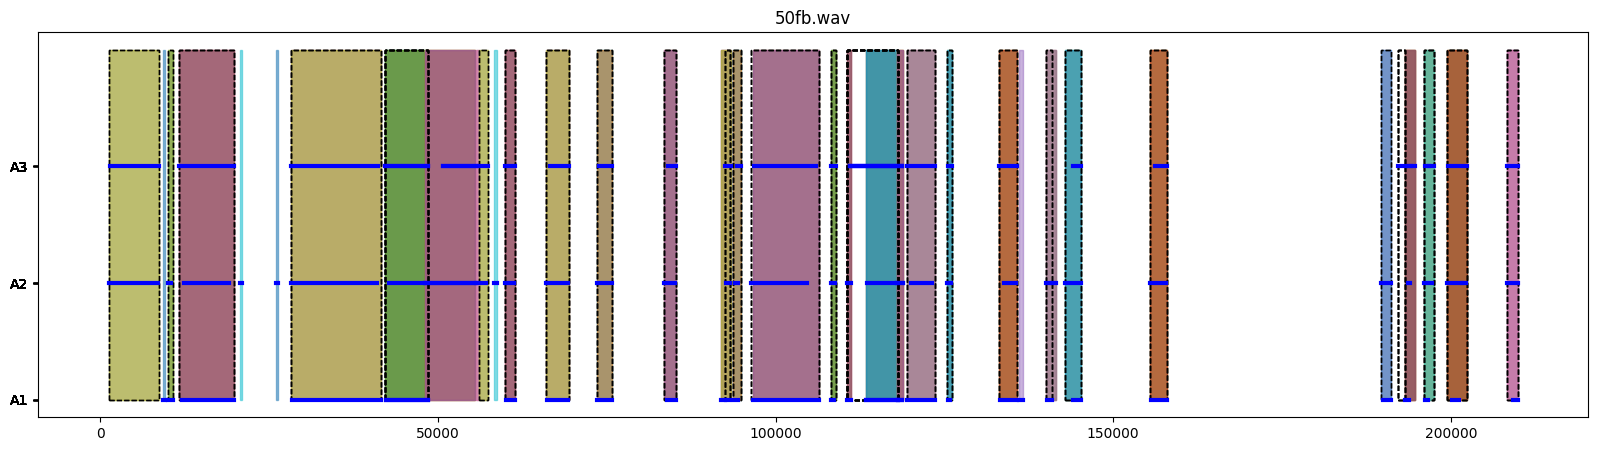

""


In [10]:
# visualize groupings
from matplotlib.patches import Rectangle
def plot_vectorranges(vr,y, color='b', linewidth=1, alpha=1):
    plt.plot([vr.start, vr.end], y, color=color, linewidth=linewidth, alpha=alpha)

def plot_ann(data):
    vrs = [va[0] for va in data['annotations']]
    ys = [i for i in data['anotator_id']]
    unique_items = data['newItemID'].unique()

    # colors = sns.color_palette('tab10', n_colors=len(unique_items))

    fig, ax = plt.subplots(figsize=(20, 5))
    for vr, y in zip(vrs, ys):
        plot_vectorranges(vr, [y,y], linewidth=3)

    colors = sns.color_palette('tab10', n_colors=len(unique_items))
    # plot the groupings
    for i,vr in enumerate(data['newItemVR']):
        color = i % len(colors)
        ax.add_patch(Rectangle((vr.start, 0), len(vr), 3, alpha=0.5, color=colors[color]))
    # plot the gold annotation with dashed rectangle
    for i,vr in enumerate(data['gold']):
        if vr:
            ax.add_patch(Rectangle((vr.start, 0), len(vr), 3, linestyle='--', facecolor='none', fill=None))

    plt.yticks(ys, data['anotator'])
    plt.title(data['origItemID'].values[0])
    plt.show()

grannodf['anotator_id'] = grannodf['anotator'].astype('category').cat.codes
grannodf['timeVr'] = grannodf['annotations'].apply(lambda x: x[0])
grannodf.iloc[:100].groupby('origItemID').apply(plot_ann)

In [22]:
# expand annotations column to multiple columns

temp_df = grannodf['annotations'].apply(lambda x: x[1])
grannodf = pd.concat([grannodf, temp_df], axis=1)
grannodf.head()

,origItemID,newItemID,newItemVR,anotator,annotations,gold,anotator_id,timeVr,0,1,...,SR,ISR,MUR,P,B,NV,V,FG,HM,ME
0,50fb.wav,402,"(9267, 9597)",A1,"[(9267, 9597), [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",None,0,"(9267, 9597)","(9267, 9597)",FP 0 SR 0 ISR 0 MUR 0 P 1 B...,...,0,0,0,1,0,0,0,0,0,0
1,50fb.wav,338,"(10050, 10738)",A1,"[(10096, 10738), [0, 0, 0, 0, 1, 0, 0, 0, 0, 0...","(10050, 10738)",0,"(10096, 10738)","(10096, 10738)",FP 0 SR 0 ISR 0 MUR 0 P 1 B...,...,0,0,0,1,0,0,0,0,0,0
2,50fb.wav,338,"(10050, 10738)",A2,"[(10050, 10550), [0, 0, 0, 0, 1, 0, 0, 0, 0, 1...","(10050, 10738)",1,"(10050, 10550)","(10050, 10550)",FP 0 SR 0 ISR 0 MUR 0 P 1 B...,...,0,0,0,1,0,0,0,0,1,0
3,50fb.wav,344,"(11710, 19850)",A1,"[(12176, 19803), [0, 0, 0, 0, 0, 0, 0, 1, 1, 0...","(11710, 19850)",0,"(12176, 19803)","(12176, 19803)",FP 0 SR 0 ISR 0 MUR 0 P 0 B...,...,0,0,0,0,0,0,1,1,0,0
4,50fb.wav,344,"(11710, 19850)",A2,"[(12470, 19020), [0, 0, 0, 0, 0, 0, 0, 1, 1, 0...","(11710, 19850)",1,"(12470, 19020)","(12470, 19020)",FP 0 SR 0 ISR 0 MUR 0 P 0 B...,...,0,0,0,0,0,0,1,1,0,0


### Calculate the iaa using Time Span only 

#### On all A1, A2 and A3

In [11]:
grannodf.head()

,origItemID,newItemID,newItemVR,anotator,annotations,gold,anotator_id,timeVr
0,50fb.wav,"50fb.wav-(9267, 9597)","(9267, 9597)",A1,"[(9267, 9597), [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",None,0,"(9267, 9597)"
1,50fb.wav,"50fb.wav-(10050, 10738)","(10050, 10738)",A1,"[(10096, 10738), [0, 0, 0, 0, 1, 0, 0, 0, 0, 0...","(10050, 10738)",0,"(10096, 10738)"
2,50fb.wav,"50fb.wav-(10050, 10738)","(10050, 10738)",A2,"[(10050, 10550), [0, 0, 0, 0, 1, 0, 0, 0, 0, 1...","(10050, 10738)",1,"(10050, 10550)"
3,50fb.wav,"50fb.wav-(11710, 19850)","(11710, 19850)",A1,"[(12176, 19803), [0, 0, 0, 0, 0, 0, 0, 1, 1, 0...","(11710, 19850)",0,"(12176, 19803)"
4,50fb.wav,"50fb.wav-(11710, 19850)","(11710, 19850)",A2,"[(12470, 19020), [0, 0, 0, 0, 0, 0, 0, 1, 1, 0...","(11710, 19850)",1,"(12470, 19020)"


In [12]:
import sys
sys.path.append('../annotationmodeling')
from agreement import InterAnnotatorAgreement

grannodf['newItemID'] = grannodf['newItemID'].astype('category').cat.codes

def inv_iou(x, y):
    return 1 - iou(x, y)
iaa = InterAnnotatorAgreement(annodf=grannodf, distance_fn=inv_iou, label_colname="timeVr", item_colname="newItemID", uid_colname="anotator_id")
iaa.setup()
print(f'Krippendorff alpha: {iaa.get_krippendorff_alpha()}')
print(f'Ks : {iaa.get_ks()}')
print(f'Sigma: {iaa.get_sigma()}')


Calculating same-item distances
Calculating different-item distances
Krippendorff alpha: 0.4294066339910775
Ks : 0.734468085106383
Sigma: 0.7395744680851064


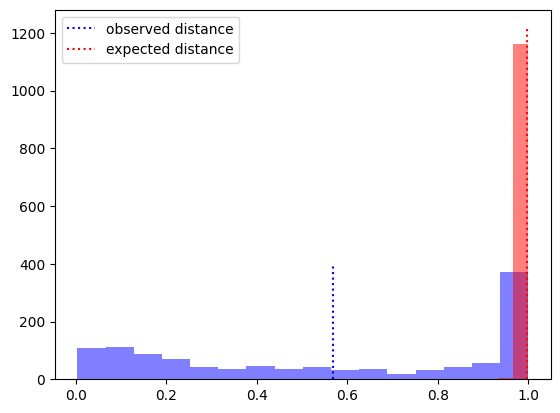

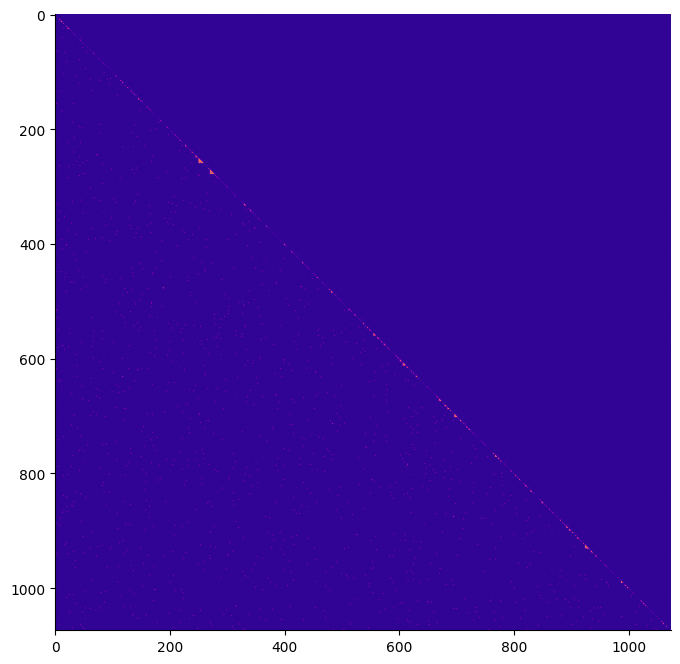

In [13]:
iaa.plot_distance_distributions()
iaa.plot_matrix(show_grid=False)

#### Only between between A1 and A3

In [14]:
grannodf_temp =  grannodf.copy()
grannodf_temp = grannodf[grannodf['anotator'].isin(['A1', 'A3'])]
grannodf_temp['anotator_id'] = grannodf_temp['anotator'].astype('category').cat.codes
iaa_temp = InterAnnotatorAgreement(annodf=grannodf_temp, distance_fn=inv_iou, label_colname="timeVr", item_colname="newItemID", uid_colname="anotator_id")
iaa_temp.setup()
print(f'Krippendorff alpha: {iaa_temp.get_krippendorff_alpha()}')
print(f'Ks: {iaa_temp.get_ks()}')
print(f'Sigma: {iaa_temp.get_sigma()}')

Calculating same-item distances
Calculating different-item distances
Krippendorff alpha: 0.39754674368982135
Ks: 0.6676557863501483
Sigma: 0.6676557863501484


/tmp/ipykernel_2487224/2704635410.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grannodf_temp['anotator_id'] = grannodf_temp['anotator'].astype('category').cat.codes


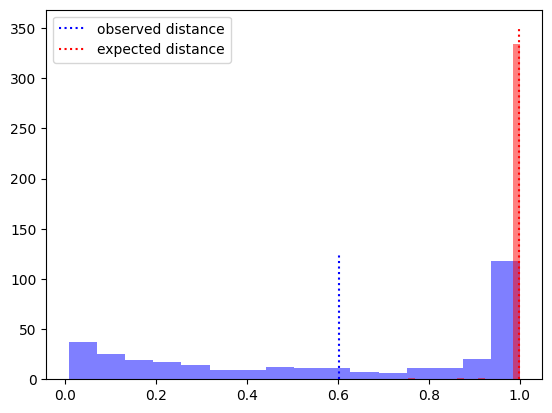

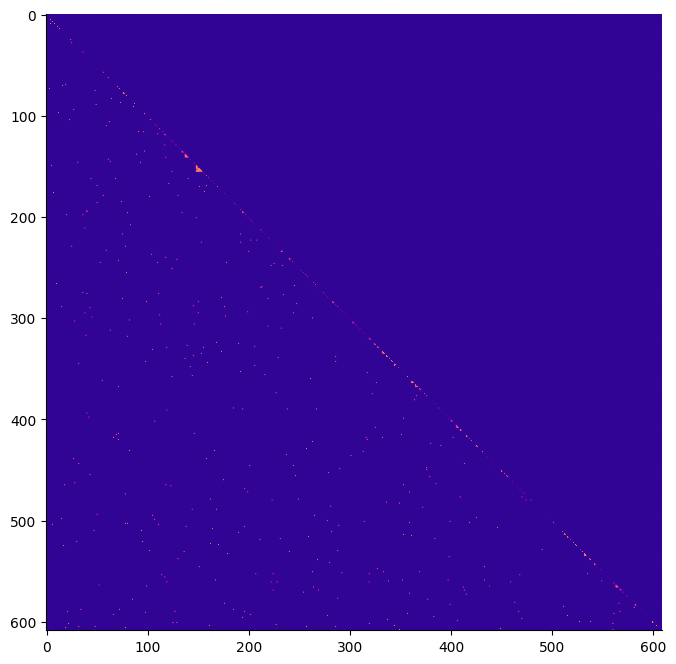

In [15]:
iaa_temp.plot_distance_distributions()
iaa_temp.plot_matrix(show_grid=False)

### Calculating IAA using using Hamming Distrance + Ordinal

In [16]:
grannodf_temp.head()

,origItemID,newItemID,newItemVR,anotator,annotations,gold,anotator_id,timeVr
0,50fb.wav,402,"(9267, 9597)",A1,"[(9267, 9597), [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",None,0,"(9267, 9597)"
1,50fb.wav,338,"(10050, 10738)",A1,"[(10096, 10738), [0, 0, 0, 0, 1, 0, 0, 0, 0, 0...","(10050, 10738)",0,"(10096, 10738)"
3,50fb.wav,344,"(11710, 19850)",A1,"[(12176, 19803), [0, 0, 0, 0, 0, 0, 0, 1, 1, 0...","(11710, 19850)",0,"(12176, 19803)"
5,50fb.wav,344,"(11710, 19850)",A3,"[(11710, 19850), [0, 0, 0, 0, 0, 0, 0, 0, 1, 0...","(11710, 19850)",1,"(11710, 19850)"
6,50fb.wav,383,"(28190, 41588)",A1,"[(28352, 41588), [0, 0, 0, 0, 0, 0, 0, 1, 0, 0...","(28190, 41588)",0,"(28352, 41588)"


In [17]:
import sys
sys.path.append('../annotationmodeling')
from agreement import InterAnnotatorAgreement

grannodf['newItemID'] = grannodf['newItemID'].astype('category').cat.codes

def inv_score(x, y):
    return score(x, y)

iaa = InterAnnotatorAgreement(annodf=grannodf, distance_fn=normalized_hamming_distance, label_colname="annotations", item_colname="newItemID", uid_colname="anotator_id")
iaa.setup()
print(f'Krippendorff alpha: {iaa.get_krippendorff_alpha()}')
print(f'Ks : {iaa.get_ks()}')
print(f'Sigma: {iaa.get_sigma()}')


Calculating same-item distances
Calculating different-item distances
Krippendorff alpha: 0.16325301204819276
Ks : 0.15063829787234043
Sigma: 0.07829787234042551


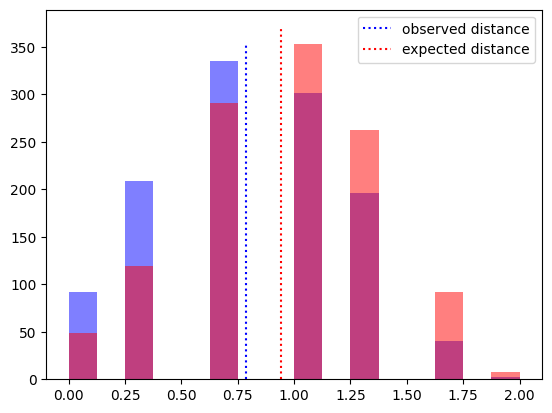

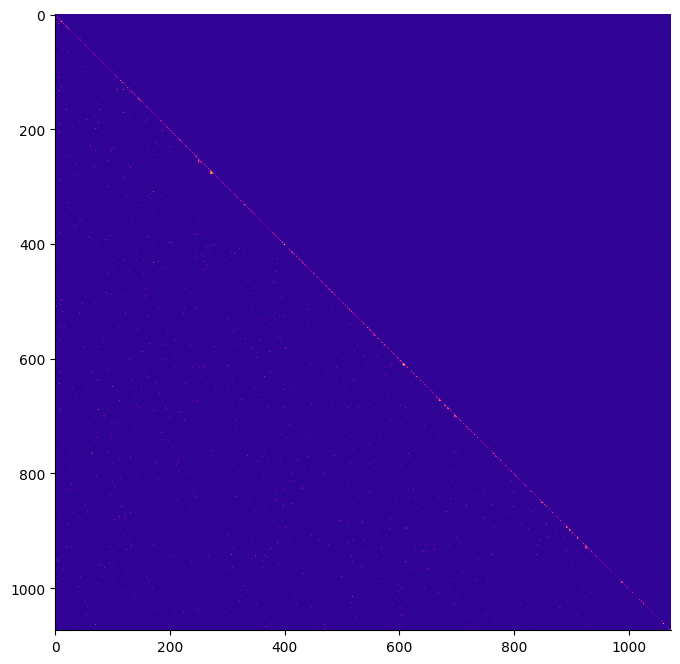

In [18]:
iaa.plot_distance_distributions()
iaa.plot_matrix(show_grid=False)

## Aggregation

In [19]:
import sys
sys.path.append("../annotationmodeling")
from experiments import RealExperiment
df = pd.read_csv('../datasets/fluencybank/csv/test/reading_test.csv')
iaa_exp = RealExperiment(eval_fn=iou,label_colname="timeVr",
                                                    item_colname="newItemID", uid_colname="anotator")
iaa_exp.setup(grannodf, golddf=grannodf, c_gold_item="newItemID", c_gold_label="timeVr")
iaa_exp.train(iter=0, masX_iter=0)
# iaa_exp.test(debug=False)

100%|██████████| 406/406 [00:00<00:00, 697.62it/s]
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f2f75b1a490cf818851956f5849af989 NOW.


Pickled model not found
Compiling model
../annotationmodeling/stan_files/dem_semisup


cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
In file included from /fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /tmp/pystan_i4ez8nz5/stanfit4anon_model_f2f75b1a490cf818851956f5849af989_1825764970189437361.cpp:1315:
/fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with "

Pickling model
Initial log joint probability = -159.675
Pickled model not found
Compiling model
../annotationmodeling/stan_files/mas2_semisup
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       4      -129.724      0.655215       59.5054           1           1        5   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       9      -25.8313       4.87492       69.9972           1           1       11   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      14      0.699887      0.631751       32.7641      0.9814      0.9814       16   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       9.06505     0.0800172       5.88311           1           1       21   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      24       12.7877      0.523908       4.65873

DIAGNOSTIC(S) FROM PARSER:
Info: Comments beginning with # are deprecated.  Please use // in place of # for line comments.
Info: Comments beginning with # are deprecated.  Please use // in place of # for line comments.

cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
In file included from /fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /tmp/pystan_o6k4dlcy/stanfit4anon_model_0a42423d6797de0c623e8873b9455595_7792309906962712306.cpp:1315:
/fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy

Pickling model
Initial log joint probability = -11271.3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       4      -3479.58      0.303421       76.6706      0.5128           1        8   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       9      -3415.16       1.54246       348.124           1           1       13   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      14      -1451.59       7.56925       1233.07        0.81        0.81       20   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -18.2578       1.05674       216.903      0.8187      0.8187       26   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      24       2244.52       2.71171       1363.02      0.5115      0.5115       33   
    Iter      log prob        ||dx||      ||grad|

In [23]:
iaa_exp.bau_preds

{0: <__main__.Vector at 0x7f11f6430700>,
 1: <__main__.Vector at 0x7f11f64308e0>,
 2: <__main__.Vector at 0x7f11f649ae80>,
 3: <__main__.Vector at 0x7f11f6430ac0>,
 4: <__main__.Vector at 0x7f11f6430ca0>,
 5: <__main__.Vector at 0x7f11f64350a0>,
 6: <__main__.Vector at 0x7f11f64a0640>,
 7: <__main__.Vector at 0x7f11f6435460>,
 8: <__main__.Vector at 0x7f11f6435820>,
 9: <__main__.Vector at 0x7f11f6435a00>,
 10: <__main__.Vector at 0x7f11f64a0820>,
 11: <__main__.Vector at 0x7f11f6435be0>,
 12: <__main__.Vector at 0x7f11f6435dc0>,
 13: <__main__.Vector at 0x7f11f6435fa0>,
 14: <__main__.Vector at 0x7f11f64391c0>,
 15: <__main__.Vector at 0x7f11f64393a0>,
 16: <__main__.Vector at 0x7f11f6439580>,
 17: <__main__.Vector at 0x7f11f64a0a00>,
 18: <__main__.Vector at 0x7f11f6439760>,
 19: <__main__.Vector at 0x7f11f6439b20>,
 20: <__main__.Vector at 0x7f11f6439d00>,
 21: <__main__.Vector at 0x7f11f6439ee0>,
 22: <__main__.Vector at 0x7f11f643e100>,
 23: <__main__.Vector at 0x7f11f643e2e0>,
 2